In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from numpy import linalg as la
import matplotlib.pylab as plt
from scipy.optimize import fsolve
import math
import statsmodels.api as sm
from scipy.stats import norm
import seaborn as sns
from scipy import stats
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from Meanfield_Dyn_util import *
from utils import *

In [2]:
import scipy
from functools import partial
def odeIntegral(x,t,J,I=0):
    x = np.squeeze(x)
    x = np.reshape(x,(len(x),1))
    # dxdt = -x+J@np.tanh(x)#+I[0]
    dxdt = -x+J@x+I[0]
    return np.squeeze(dxdt)
def odesimulation(t,xinit,Jpt,I):
	return scipy.integrate.odeint(partial(odeIntegral,J=Jpt,I=I),xinit,t)
shiftx = 1.5
def odeIntegralP(x,t,J,I=0):
	x = np.squeeze(x)
	x = np.reshape(x,(len(x),1))
	# print('size:',np.shape(x),np.shape(J@np.tanh(x)))
	dxdt = -x+J@(1.0+np.tanh(x-shiftx))
	return np.squeeze(dxdt)
def odesimulationP(t,xinit,Jpt,I):
	return scipy.integrate.odeint(partial(odeIntegralP,J=Jpt,I=I),xinit,t)

In [4]:
### define the network parameters of the adjacency matrix
N  = 1500
Kt = int(N*0.2)
J = 1/np.sqrt(N)*0.5  ### TODO: make sure this scalar with David&Stefano's paper
J = 0.00325 ## ensure the mean connectivity is in nonISN regime
ntau   = 10
trials = 30+6
tau_series = np.linspace(0,0.15,ntau) ## the impact of the chain motifs is larger in this situation
switch = 1
## arrays to store results
## norml0_series: norm of left eigenvector(deltaliri = 1)
eigvchn_series, eigrvec_series, eiglvec_series = np.zeros((trials,ntau,N),dtype=complex), np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))
eiglvec0_series, norml0_series = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau+1,N)) 
### also have the reconstructed left and right eigenvectors 
eigrvec_series_rec, eiglvec_series_rec = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))
htau = tau_series[1]-tau_series[0]
### simulation using the low-rank framework
firing_rateeq = np.zeros((trials,ntau,N))

g, gamma =  6, 1/4.0
NE = int(N/(1+gamma))
NI = N-NE#NE*gamma
N  = NE+NI ### update 
ALPHAE, ALPHAI = NE/N, NI/N
KE, KI = int(Kt/(1+gamma)), int(Kt/(1+gamma)*gamma) ### fixed out-degree
ce, ci = KE/NE, KI/NI
print('ce and ci:',ce,ci)
### assert that the differences between ce and ci are smaller than epsilon
epsilon = 1E-2
assert np.abs(ce-ci)<epsilon
# assert ce==ci
c = ce
ji,je = g*J,J 
### define the network parameters of the diluted Gaussian matrix 
ge, gi = np.sqrt(je**2*c*(1-c)*N), np.sqrt(ji**2*c*(1-c)*N) 
hat_sigmae, hat_sigmai = np.sqrt(c*(1-c)), np.sqrt(c*(1-c))### standard deviation of the adjacency matrix
sigmae,sigmai = np.sqrt(c*(1-c)*J**2*N), np.sqrt(c*(1-c)*(-g*J)**2*N)### with magnitude of the coupling
JE,JI = je*c*NE, ji*c*NI 
lambda0 = JE-JI 
### mean connectivity
nvec, mvec = np.zeros((N,1)), np.ones((N,1))
nvec[:NE,0], nvec[NE:,0] = N*JE/NE, -N*JI/NI
Jbar = mvec@nvec.T/N 
## TEST THE EIGENVALUES OF THE MEAN MATRIX 
eigvJ0, eigvecJ0 = la.eig(Jbar)
print('eigvJ0:',eigvJ0[0],' theory:',JE-JI)
### mean left and right eigenvectors
leigvec0, reigvec0 = np.zeros((N,N)), np.zeros((N,N))
norm_left = np.zeros(2)
## first eigenvector
leigvec0[:,0], reigvec0[:,0] = nvec[:,0]/(JE-JI)/np.sqrt(N), mvec[:,0]/np.sqrt(N)
norm_left[0]  = la.norm(leigvec0[:,0])
leigvec0[:,0] = leigvec0[:,0]/norm_left[0]
norml0_series[:,0,0] = np.sum(leigvec0[:,0]*reigvec0[:,0])
## second eigenvector
kk = np.sqrt(NE*JI**2+NI*JE**2)
reigvec0[:NE,1], reigvec0[NE:,1] = JI/kk,JE/kk 
leigvec0[:NE,1], leigvec0[NE:,1] = -kk/(JE-JI)/NE,kk/(JE-JI)/NI 
norm_left[1]     = la.norm(leigvec0[:,1])
leigvec0[:,1] = leigvec0[:,1]/norm_left[1]
norml0_series[:,0,1] = np.sum(leigvec0[:,1]*reigvec0[:,1])
outerproduct  = np.sum(leigvec0[:,0]*reigvec0[:,1])#*norm_left
print('JE:',JE,'JI:',JI)

ce and ci: 0.2 0.2
eigvJ0: (-0.3899999999999837+0j)  theory: -0.39000000000000024
JE: 0.7799999999999999 JI: 1.1700000000000002


In [5]:
#### constant and deterministic input signal
Inp   = np.squeeze(np.ones((N,1)))/np.sqrt(N) 
Ipert = np.squeeze(np.ones((N,1)))/np.sqrt(N) 
# Ipert[NE:]=0 ## excitatory input to excitatory neurons
Ipert[:NE]=0 ## excitatory input to inhibitory neurons 
tt = np.linspace(0,200,1000)

In [6]:
### generate i.i.d. s
def randbin(M,N,P):  
    return np.random.choice([0, 1], size=(M,N), p=[P, 1-P])


### response of sparse networks with iid bernoulli connectivity 
sparseiid_dyns = np.zeros((trials,N,1))
for ktrial in range(trials):
    ### generate iid sparse connectivity 
    Ecol = randbin(1,NE*N,1-ce)
    Icol = randbin(1,NI*N,1-ci)
    Ecol = np.reshape(Ecol,(N,NE))
    Icol = np.reshape(Icol,(N,NI))
    iidsparse = np.zeros((N,N))
    iidsparse[:,:NE], iidsparse[:,NE:] = Ecol.copy()*J,Icol.copy()*J*(-g)
    xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
    xtemporal = odesimulation(tt, xinit, iidsparse, Inp)
    firing_rate0 = np.reshape(xtemporal[-1,:N],(N,1))
    sparseiid_dyns[ktrial,:,:] = firing_rate0.copy()
    
sparseiid_dyns = np.squeeze(sparseiid_dyns)
mean_sparseiid_dyns = np.zeros((trials,2))
for ktrial in range(trials):
    mean_sparseiid_dyns[ktrial,0],mean_sparseiid_dyns[ktrial,1]= np.mean(sparseiid_dyns[ktrial,:NE]),np.mean(sparseiid_dyns[ktrial,NE:])
trialavg_sparseiid_dyns = np.mean(mean_sparseiid_dyns,axis=0)
trialstd_sparseiid_dyns = np.std(mean_sparseiid_dyns,axis=0)
print(trialavg_sparseiid_dyns)

[0.01859667 0.01856853]


In [ ]:
Inp   = np.squeeze(np.ones((N,1)))/np.sqrt(N) 
firing_ratepert = np.zeros((trials,ntau,N))
temporal_fr = np.zeros((trials,ntau,N,1000))
temporal_perturb_fr = np.zeros((trials,ntau,N,1000))
eiglvec0norm_series= np.zeros((trials,ntau,N,2))
leig0mean_series = np.zeros((trials,ntau,N,2))
leig0pre_series = np.zeros((trials,ntau,N,2))

norm_4rvec_series, norm_4lvec_series = np.zeros((trials,ntau,2)),np.zeros((trials,ntau,2))
norm_4lvec_series_ = np.zeros((trials,ntau,2))
flag_run = True
mode = 'heterogeneous'#'nonneg'#'normal'#
'''MODE 
There are in total three modes for Sparse networks featuring with Chain motifs:
1. heterogeneous
    tau_ee = tau_ii = fixed, maximum 0.15; while tau_ie=tau_ei gradually decrease from 0 to -0.15
2. normal 
    the normal case where tau_ee=tau_ii=-tau_ie=-tau_ei gradually increase from 0 to 0.15
3. nonneg(non negative)
    tau_ei = tau_ie == 0; while tau_ee=tau_ii gradually increase from 0 to 0.15 
'''
for ktrial in range(trials):
    print('~~~~~~~~~~~trial:',ktrial,'~~~~~~~~~~~~~~~')
    # while (flag_run):  
    while(flag_run): 
        xr      = iidGaussian([0,1/np.sqrt(N)],[N,N])
        chneta  = iidGaussian([0,1/np.sqrt(N)],[N,6])
        xrec    = iidGaussian([0,1/np.sqrt(N)],[N,N])
        ### zscore
        xr   = stats.zscore(xr.flatten())
        xr   = xr*1/np.sqrt(N)
        xr   = np.reshape(xr,(N,N))
        ### zscore
        xrec = stats.zscore(xrec.flatten())
        xrec = xrec*1/np.sqrt(N)
        xrec = np.reshape(xrec,(N,N))
        # ### zscore
        # nsample = 20
        chneta  = iidGaussian([0,1/np.sqrt(N)],[N,6])
        chneta[:,0] = stats.zscore(chneta[:,0])
        chneta[:,0] *=(1/np.sqrt(N))
        
        chneta[:,1] = stats.zscore(chneta[:,1])
        chneta[:,1] *=(1/np.sqrt(N))
        
        chneta[:,2] = stats.zscore(chneta[:,2])
        chneta[:,2] *=(1/np.sqrt(N))  
        if mode == 'heterogeneous':
            ''' heterogeneous '''
            aee,aii = np.sqrt(np.abs(tau_series[-1])),np.sqrt(np.abs(tau_series[-1]))
            # aee,aii = np.sqrt(np.abs(0.12)),np.sqrt(np.abs(0.12))#np.sqrt(np.abs(0.1)),np.sqrt(np.abs(0.1))#
            aei,aie = np.sqrt(np.abs(tau_series[-1])),np.sqrt(np.abs(tau_series[-1]))
            zrowe = np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
            zcole = np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
            
            zrowi = np.repeat(np.reshape(chneta[:,1],(1,-1)),N,axis=0)
            zcoli = np.repeat(np.reshape(chneta[:,1],(-1,1)),N,axis=1)
            
            
            sgnn = 1
            
            z_ee = np.zeros((NE,NE))
            z_ee = aee*(zcole[:NE,:NE])+aee*(zrowe[:NE,:NE])+aei*(zrowi[:NE,:NE])+np.sqrt(1-aee**2-aee**2-aei**2)*xr[:NE,:NE]
            
            z_ii = np.zeros((NI,NI))
            z_ii = aii*(zcoli[NE:,NE:])+aie*(zrowe[NE:,NE:])+aii*(zrowi[NE:,NE:])+np.sqrt(1-aii**2-aie**2-aii**2)*xr[NE:,NE:]
            
            z_ei = np.zeros((NE,NI))
            z_ei = sgnn*aei*(zcoli[:NE,NE:])+aie*(zrowe[:NE,NE:])+aii*(zrowi[:NE,NE:])+np.sqrt(1-aei**2-aie**2-aii**2)*xr[:NE,NE:]
            
            z_ie = np.zeros((NI,NE))
            z_ie = sgnn*aie*(zcole[NE:,:NE])+aee*(zrowe[NE:,:NE])+aei*(zrowi[NE:,:NE])+np.sqrt(1-aie**2-aee**2-aei**2)*xr[NE:,:NE]
            
            zr = np.zeros((N,N))
            zr[:NE,:NE] = z_ee.copy()
            zr[NE:,NE:] = z_ii.copy()
            zr[:NE,NE:] = z_ei.copy()
            zr[NE:,:NE] = z_ie.copy()
            
            ### E-I matrix 
            zr[:,:NE],zr[:,NE:] = zr[:,:NE]*ge,zr[:,NE:]*(-gi)   
        elif mode == 'normal':
            ''' Normal '''
            tau = tau_series[-1]
            a    = np.sqrt(tau)
            zrow = a*np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
            zcol = a*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
            gammarec = a*xrec-a*xrec.copy().T
            ### adjacency matrix
            zr   = zrow.copy()+zcol.copy()+np.sqrt(1-2*tau)*xr### without considering the reciprocal term
            ### E-I matrix 
            zr[:,:NE],zr[:,NE:] = zr[:,:NE]*ge,zr[:,NE:]*(-gi)   
                    
        elif mode == 'nonneg':
            ''' nonneg '''
            aee,aii = np.sqrt(np.abs(tau_series[-1])),np.sqrt(np.abs(tau_series[-1]))
            # aee,aii = np.sqrt(np.abs(0.12)),np.sqrt(np.abs(0.12))#np.sqrt(np.abs(0.1)),np.sqrt(np.abs(0.1))#
            aei,aie = 0, 0
            zrowe = np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
            zcole = np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
            
            zrowi = np.repeat(np.reshape(chneta[:,1],(1,-1)),N,axis=0)
            zcoli = np.repeat(np.reshape(chneta[:,1],(-1,1)),N,axis=1)
            
            
            sgnn = 1
            
            z_ee = np.zeros((NE,NE))
            z_ee = aee*(zcole[:NE,:NE])+aee*(zrowe[:NE,:NE])+aei*(zrowi[:NE,:NE])+np.sqrt(1-aee**2-aee**2-aei**2)*xr[:NE,:NE]
            
            z_ii = np.zeros((NI,NI))
            z_ii = aii*(zcoli[NE:,NE:])+aie*(zrowe[NE:,NE:])+aii*(zrowi[NE:,NE:])+np.sqrt(1-aii**2-aie**2-aii**2)*xr[NE:,NE:]
            
            z_ei = np.zeros((NE,NI))
            z_ei = sgnn*aei*(zcoli[:NE,NE:])+aie*(zrowe[:NE,NE:])+aii*(zrowi[:NE,NE:])+np.sqrt(1-aei**2-aie**2-aii**2)*xr[:NE,NE:]
            
            z_ie = np.zeros((NI,NE))
            z_ie = sgnn*aie*(zcole[NE:,:NE])+aee*(zrowe[NE:,:NE])+aei*(zrowi[NE:,:NE])+np.sqrt(1-aie**2-aee**2-aei**2)*xr[NE:,:NE]
            
            zr = np.zeros((N,N))
            zr[:NE,:NE] = z_ee.copy()
            zr[NE:,NE:] = z_ii.copy()
            zr[:NE,NE:] = z_ei.copy()
            zr[NE:,:NE] = z_ie.copy()
            
            ### E-I matrix 
            zr[:,:NE],zr[:,NE:] = zr[:,:NE]*ge,zr[:,NE:]*(-gi)  
            
        '''  check the eigenvalues of the matrix '''
        Jchn = Jbar.copy()+zr.copy()
        eigvchn, eigrvec = la.eig(Jchn)
        print(eigvchn[:2])
        if eigvchn[0].imag==0 and eigvchn[1].imag==0:
            flag_run = False
    
    ### ---------------------
    print('Go run...........................')
    intg_ov  = np.zeros(2) ### rank
    intg_ovP = np.zeros((2,2,2)) ### rank, rank, population
    intg_ml, intg_mr = leigvec0.copy(), reigvec0.copy()
    mean_pre = np.array([JE-JI,0])
    mean_total_change = np.zeros(2)
    z_pre = np.zeros((N,N))
    for it, tau in enumerate(tau_series[:]):
        if mode == 'heterogeneous':
            ''' heterogeneous '''
            aee,aii = np.sqrt(np.abs(tau_series[-1])),np.sqrt(np.abs(tau_series[-1]))
            aei,aie = np.sqrt(np.abs(tau)),np.sqrt(np.abs(tau))
            zrowe = np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
            zcole = np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
            
            zrowi = np.repeat(np.reshape(chneta[:,1],(1,-1)),N,axis=0)
            zcoli = np.repeat(np.reshape(chneta[:,1],(-1,1)),N,axis=1)
            
            if tau<0:
                sgnn = -1
            else:
                sgnn = 1
        
            ### zee and zii    
            z_ee = np.zeros((NE,NE))
            z_ee = aee*(zcole[:NE,:NE])+aee*(zrowe[:NE,:NE])+aei*(zrowi[:NE,:NE])+np.sqrt(1-aee**2-aee**2-aei**2)*xr[:NE,:NE]
            
            z_ii = np.zeros((NI,NI))
            z_ii = aii*(zcoli[NE:,NE:])+aie*(zrowe[NE:,NE:])+aii*(zrowi[NE:,NE:])+np.sqrt(1-aii**2-aie**2-aii**2)*xr[NE:,NE:]
            
            z_ei = np.zeros((NE,NI))
            z_ei = sgnn*aei*(zcoli[:NE,NE:])+aie*(zrowe[:NE,NE:])+aii*(zrowi[:NE,NE:])+np.sqrt(1-aei**2-aie**2-aii**2)*xr[:NE,NE:]
            
            z_ie = np.zeros((NI,NE))
            z_ie = sgnn*aie*(zcole[NE:,:NE])+aee*(zrowe[NE:,:NE])+aei*(zrowi[NE:,:NE])+np.sqrt(1-aie**2-aee**2-aei**2)*xr[NE:,:NE]
            
            zr = np.zeros((N,N))
            zr[:NE,:NE] = z_ee.copy()
            zr[NE:,NE:] = z_ii.copy()
            zr[:NE,NE:] = z_ei.copy()
            zr[NE:,:NE] = z_ie.copy()
            
            ### convergent
            zree, zrei = zr[:NE,:NE].copy(),zr[:NE,NE:].copy()
            conve_ei = np.mean((zrei.T@zree).flatten())/NE*N  
            conve_ee = np.mean((zree.T@zree).flatten())/NE*N
            conve_ii = np.mean((zrei.T@zrei).flatten())/NE*N  
            
            zrii, zrie = zr[NE:,NE:].copy(),zr[NE:,:NE].copy()
            convi_ei = np.mean((zrii.T@zrie).flatten())/NI*N  
            convi_ee = np.mean((zrie.T@zrie).flatten())/NI*N  
            convi_ii = np.mean((zrii.T@zrii).flatten())/NI*N   

            
            ### divergent 
            divee_e = np.mean((zree@zree.T).flatten())/NE*N 
            divii_e = np.mean((zrie@zrie.T).flatten())/NE*N    
            divei_e = np.mean((zree@zrie.T).flatten())/NE*N  
            
            divee_i = np.mean((zrei@zrei.T).flatten())/NI*N 
            divii_i = np.mean((zrii@zrii.T).flatten())/NI*N 
            divei_i = np.mean((zrei@zrii.T).flatten())/NI*N    

            ### reciprocal 
            rec_ee = np.mean(np.diag(zree@zree))/NE*N  
            rec_ii = np.mean(np.diag(zrii@zrii))/NI*N 
            rec_ei = np.mean(np.diag(zrei@zrie))/NI*N   
            rec_ie = np.mean(np.diag(zrie@zrei))/NE*N  
        
            ### E-I matrix 
            zr[:,:NE],zr[:,NE:] = zr[:,:NE]*ge,zr[:,NE:]*(-gi)   
        elif mode == 'normal':
            ''' Normal'''
            a    = np.sqrt(tau)
            zrow = a*np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
            zcol = a*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
            gammarec = a*xrec-a*xrec.copy().T
            ### adjacency matrix
            zr   = zrow.copy()+zcol.copy()+np.sqrt(1-2*tau)*xr### without considering the reciprocal term
            ### E-I matrix 
            zr[:,:NE],zr[:,NE:] = zr[:,:NE]*ge,zr[:,NE:]*(-gi) 
        elif mode == 'nonneg':
            ''' nonneg '''
            aee,aii = np.sqrt(np.abs(tau)),np.sqrt(np.abs(tau))
            aei,aie = 0,0
            zrowe = np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
            zcole = np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
            
            zrowi = np.repeat(np.reshape(chneta[:,1],(1,-1)),N,axis=0)
            zcoli = np.repeat(np.reshape(chneta[:,1],(-1,1)),N,axis=1)
            
            if tau<0:
                sgnn = -1
            else:
                sgnn = 1
        
            ### zee and zii    
            z_ee = np.zeros((NE,NE))
            z_ee = aee*(zcole[:NE,:NE])+aee*(zrowe[:NE,:NE])+aei*(zrowi[:NE,:NE])+np.sqrt(1-aee**2-aee**2-aei**2)*xr[:NE,:NE]
            
            z_ii = np.zeros((NI,NI))
            z_ii = aii*(zcoli[NE:,NE:])+aie*(zrowe[NE:,NE:])+aii*(zrowi[NE:,NE:])+np.sqrt(1-aii**2-aie**2-aii**2)*xr[NE:,NE:]
            
            z_ei = np.zeros((NE,NI))
            z_ei = sgnn*aei*(zcoli[:NE,NE:])+aie*(zrowe[:NE,NE:])+aii*(zrowi[:NE,NE:])+np.sqrt(1-aei**2-aie**2-aii**2)*xr[:NE,NE:]
            
            z_ie = np.zeros((NI,NE))
            z_ie = sgnn*aie*(zcole[NE:,:NE])+aee*(zrowe[NE:,:NE])+aei*(zrowi[NE:,:NE])+np.sqrt(1-aie**2-aee**2-aei**2)*xr[NE:,:NE]
            
            zr = np.zeros((N,N))
            zr[:NE,:NE] = z_ee.copy()
            zr[NE:,NE:] = z_ii.copy()
            zr[:NE,NE:] = z_ei.copy()
            zr[NE:,:NE] = z_ie.copy()
        
            ### E-I matrix 
            zr[:,:NE],zr[:,NE:] = zr[:,:NE]*ge,zr[:,NE:]*(-gi)      
    
        # zr2 = zr@zr   
        # print('tau:',tau)
        # print('zee2:',np.mean((zr[:NE,:NE]@zr[:NE,:NE]).flatten())/NE/(je**2)/c/(1-c))
        # print('zii2:',np.mean((zr[NE:,NE:]@zr[NE:,NE:]).flatten())/NI/(ji**2)/c/(1-c))
        
        # print('zei2:',np.mean((zr[:NE,:NE]@zr[:NE,NE:]).flatten())/NE/(je*ji)/c/(1-c))
        # print('zIE2:',np.mean((zr[:NE,NE:]@zr[NE:,:NE]).flatten())/NI/(ji*je)/c/(1-c))
        

        DELTA_Z = zr-z_pre
        hzr     = DELTA_Z.copy()
        ### generate J connectivity matrix
        Jchn = Jbar.copy()+zr.copy()
        ### full rank simulation
        xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
        xc_temporal = odesimulation(tt, xinit, Jchn, Inp)
        temporal_fr[ktrial,it,:,:] = np.squeeze(xc_temporal.T).copy()
        firing_rateeq[ktrial,it,:] = xc_temporal[-1,:].copy()
        ### perturbation 
        xpert = xc_temporal[-1,:].copy()
        xpert = xpert.reshape(-1,1)
        dtt =tt[1]-tt[0]
        xc_temporal_perturb = []
        for ttt in range(len(tt)):
            delta_x= -xpert + Jchn@xpert.reshape(-1,1)+Ipert.reshape(-1,1)+Inp.reshape(-1,1)
            xpert = delta_x*dtt+xpert 
            xc_temporal_perturb.append(xpert)
        firing_ratepert[ktrial,it,:] = xpert.copy().squeeze()
        temporal_perturb_fr[ktrial,it,:,:] = np.squeeze(np.array(xc_temporal_perturb).T)
        
        
        eigvchn, eigrvec = la.eig(Jchn)
        
        eigvchn_,eiglvec = la.eig(Jchn.copy().T)
        ### normalization
        reig  = np.squeeze(eigrvec[:,:].copy())
        leig0 = np.squeeze(eiglvec[:,:].copy()) 
        normval = np.sum(reig.copy()*leig0.copy(),axis=0)
        norml0_series[ktrial,it+1,:] = normval.copy() ### normalization factor shift right 1byte
        normval = np.repeat(np.reshape(normval,(1,N)),N,axis=0)
        leig    = leig0.copy()/normval.copy() ### left eigenvector normalization
        
        ### sort the eigenvalues by the real part
        if eigvchn[0].real>eigvchn[1].real:
            idxsort = [1,0]
        else:
            idxsort = [0,1]
        eigvchn[:2] = eigvchn[idxsort]
        reig[:,:2] = reig[:,idxsort]
        leig[:,:2] = leig[:,idxsort]
        leig0[:,:2] = leig0[:,idxsort]
        
        if np.mean(reig[:NE,0])*np.mean(reigvec0[:NE,0])<0:
            reig[:,0]*=-1
            leig[:,0]*=-1
            leig0[:,0]*=-1
        if np.mean(reig[:NE,1])<0: ### the second rank-1 component is negative
            reig[:,1]*=-1
            leig[:,1]*=-1
            leig0[:,1]*=-1
            
        z_pre = zr.copy()
        flag_run = True
         

#### Mode#1 heterogeneous(transition) (Fig 11(a) pointing from yellow arrowhead to purple arrowhead)

$\tau_{EE}=\tau_{II}= 0.15,\,\,\,\,\tau_{EI}=\tau_{IE}\in[0,-0.15]$

In [8]:
data_name = "E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/equivalentGaussian/ConnStats_WD_AdjGau_22May_t200ms_PRX_N1500_transition_INHparadoxical.npz"#ConnStats_WD_AdjGau_22May_t200ms_PRX_N1500_nonneg_nonparadoxical_INHparadoxical.npz"
# data_name = "/Users/shaoyuxiu/Library/CloudStorage/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/equivalentGaussian/ConnStats_WD_AdjGau_22May_t200ms_PRX_N1500_transition_INHparadoxical.npz"#

# np.savez(data_name, **data)
### load data  
data = np.load(data_name,allow_pickle=True)
eigvchn_series = data['eigvchn_series']
eigrvec_series = data['eigrvec_series']
eiglvec_series = data['eiglvec_series']
eiglvec0_series = data['eiglvec0_series']
norml0_series = data['norml0_series']
params = data['params']
intg_ov_series = data['intg_ov_series']
first_perturb_ov = data['first_perturb_ov']
first_perturb_ovP = data['first_perturb_ovP']
intg_mean_series = data['intg_mean_series']
intg_std_series = data['intg_std_series']
intg_std_num_series = data['intg_std_num_series']

firing_rateeq = data['firing_rateeq']
firing_ratepert = data['firing_ratepert']

g = params[()]['g']
gamma = params[()]['gamma']
NE = params[()]['NE']
NI = params[()]['NI']
J = params[()]['J']
ce = params[()]['ce']
ci = params[()]['ci']
tau_series = params[()]['tau_series']

In [ ]:
'''mode1--eigenvalue outliers (theo)'''
tauc = np.abs(tau_series[-1]) ## constant tauEE = tauII=0.15
zee=J**2*c*(1-c)*NE*tauc*np.ones_like(tau_series) -g*J**2*c*(1-c)*NI*tau_series
zii= -g*J**2*c*(1-c)*NE*tau_series+g**2*J**2*c*(1-c)*NI*tauc*np.ones_like(tau_series) 
nvec, mvec = np.zeros((N,1)), np.ones((N,1))
nvec[:NE,0], nvec[NE:,0] = JE/NE, -JI/NI
def case1eigv(x,J,g,NE,NI,c,tau):
    tauc = np.abs(tau_series[-1])
    zee = J**2*c*(1-c)*NE*tauc-g*J**2*c*(1-c)*NI*tau
    zii = -g*J**2*c*(1-c)*NE*tau+g**2*J**2*c*(1-c)*NI*tauc 
    # print((NE*zee+NI*zii)*4+(JE-JI)**2)
    z2lambda = np.zeros((N,N))
    z2lambda[:,:NE], z2lambda[:,NE:] = zee/x**2,zii/x**2 
    z2lambda = np.eye(N)-z2lambda 
    final = nvec.T@la.inv(z2lambda)@mvec 
    final = np.squeeze(final)
    return final-x

### solve x 
eigvchn_theo = np.zeros((ntau,2))
for it, tau in enumerate(tau_series):
    if it<=-1:
        continue
    x = fsolve(case1eigv,np.mean(eigvchn_series[:,it,1].real),args=(J,g,NE,NI,c,tau))
    eigvchn_theo[it,1] = x 
    print('tau:',tau,'eigv:',x)
    x = fsolve(case1eigv,np.mean((eigvchn_series[:,it,0]).real),args=(J,g,NE,NI,c,tau))
    eigvchn_theo[it,0] = x 
    
    print('tau:',tau,'eigv:',x)
    print('numerical:',np.mean(eigvchn_series[:,it,:2],axis=0))


In [10]:
### compute the theoretical outliers and the spectral radius
### recording
radius_theo_map = np.zeros(ntau)
### print variables and parameters of the adjacency matrix 
print('-------------------')
print('N:',N)
print('g:',g)
print('gamma:',gamma)
print('J:',J)
print('JE,JI:',JE,JI)
print('ge,gi:',ge,gi)
print('c:',c)
print('je,ji:',je,ji)
print('-------------------')
ce, ci = c,c
for it, tau in enumerate(tau_series):
    ### mean connectivity 
    je, ji = J, g*J
    hat_sigmae, hat_sigmai = np.sqrt(ce*(1-ce)),np.sqrt(ci*(1-ci))
    sigmae, sigmai = np.sqrt(je**2*ce*(1-ce)*N), np.sqrt(ji**2*ci*(1-ci)*N) 
    ### generate tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec
    tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec = np.zeros(2),np.zeros((2,2)),np.zeros((2,2)),np.zeros((2,2))
    ### YS: alltaus do not have E-I polarity
    tau_div_vec = np.array([tau,tau])
    tau_con_vec = np.array([[tau,tau],[tau,tau]])
    # tau_rec_vec = np.array([[0,0],[0,0]])
    tau_rec_vec = np.array([[2*tau,2*tau],[2*tau,2*tau]])
    tau_chn_vec = np.array([[tau,tau],[tau,tau]])
    # gamma = 1.0 ## NI/NE
    sigma = np.sqrt(sigmae**2/(1+gamma)+sigmai**2*gamma/(1+gamma))
    ### compute the radius 
    # compute a single number for multiple populations
    tau_div_num = hat_sigmae**2*tau_div_vec[0]+gamma*g**2*hat_sigmai**2*tau_div_vec[1]
    tau_div_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_div = tau_div_num/tau_div_den

    tau_con_num = hat_sigmae**2*tau_con_vec[0,0]+gamma*g**2*hat_sigmai**2*tau_con_vec[1,1]
    tau_con_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_con  = tau_con_num/tau_con_den

    tau_rec_num = hat_sigmae**2*tau_rec_vec[0,0] - (1+gamma)*g*hat_sigmae*hat_sigmai*tau_rec_vec[0,1]+gamma*g**2*hat_sigmai**2*tau_rec_vec[1,1]
    tau_rec_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_rec = tau_rec_num/tau_rec_den/2.0 

    tau_chn_num = hat_sigmae**2*tau_chn_vec[0,0] - 0.5*(1+gamma)*g*hat_sigmae*hat_sigmai*(tau_chn_vec[0,1]+tau_chn_vec[1,0])+gamma*g**2*hat_sigmai**2*tau_chn_vec[1,1]
    tau_chn_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_chn = tau_chn_num/tau_chn_den/2.0

    radius_theo = (1.0-tau_con-tau_div+tau_rec-2*tau_chn)/np.sqrt(1-tau_con-tau_div)*sigma
    
    radius_theo_map[it] = radius_theo
            

-------------------
N: 1500
g: 6
gamma: 0.25
J: 0.00325
JE,JI: 0.7799999999999999 1.1700000000000002
ge,gi: 0.05034878350069642 0.3020927010041785
c: 0.2
je,ji: 0.00325 0.0195
-------------------


In [12]:
### sorting the 3 maximum eigvchn_series[:,-1,0].real and 3 minimum
eigvchn_real = eigvchn_series[:,-1,0].real.copy()
### sorting eigvchn_real 
idx = np.argsort(eigvchn_real)
idx_eff = idx[3:-3]#idx#
print('effective trials:',idx_eff,len(idx_eff))

effective trials: [30  3  5 11 10 23 24 19 34 33  2 28  1  9  6  4 14 22  8 17 13 25 32 18
 21 31 12 16  7 15] 30


In [13]:
### compute the numerical radius
# trials = 36
# ntau = 10
radius_num_map = np.zeros((trials,ntau))
for ktrial in range(trials):
    for it in range(ntau): 
        eigvchn = eigvchn_series[ktrial,it,:].copy()

        eigvchn_real = np.real(eigvchn)
        eigvchn_real = np.sort(eigvchn_real)
        eigvchn_real = eigvchn_real[::-1]

        radius = (eigvchn_real[2])
        radius_num_map[ktrial,it] = radius


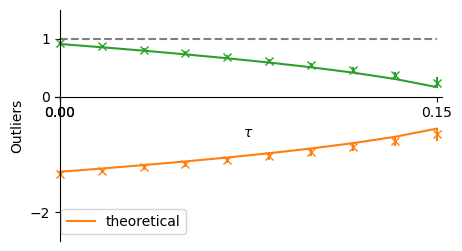

In [17]:
### plot the numerical and theoretical eigenvalues outliers
fig,ax = plt.subplots(figsize=(5,3))

ax.plot(tau_series,eigvchn_theo[:,0],'tab:orange',label='theoretical')
ax.plot(tau_series,eigvchn_theo[:,1],'tab:green')

ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,0].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,0].real,axis=0),fmt='x',color='tab:orange',ecolor='tab:orange',alpha=1,ls='',elinewidth=1.5)
ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,1].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,1].real,axis=0),fmt='x',color='tab:green',ecolor='tab:green',alpha=1,ls='',elinewidth=1.5)
    
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Outliers')
### set x and y lims as well as ticks
dtau = tau_series[1]-tau_series[0] 
ax.set_xlim([tau_series[0]-dtau/8,tau_series[-1]+dtau/8])
ax.set_xticks([0,tau_series[-1]//2,tau_series[-1]])
ax.set_ylim([-2.5,1.5])
ax.set_yticks([-2,0,1])
ax.set_ylim([-4.5,3.5])
ax.set_yticks([-4,0,3])

ax.set_ylim([-2.5,1.5])
ax.set_yticks([-2,0,1])
### plot y==1 
ax.plot([0,tau_series[-1]],[1,1],color='gray',linestyle='--',linewidth=1.5)
ax.legend()
### move the x and y axis to the center
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.show()

In [18]:
### numerical
mean_reigvec_num_series = np.zeros((trials,ntau,2,2))
mean_leigvec_num_series = np.zeros((trials,ntau,2,2))
mean_leig0vec_num_series = np.zeros((trials,ntau,2,2))
thl = 15
ths = 15

                
### for the numerical 
for ktrial in range(trials):
    for it in range(ntau):
        if it<2:
            threshold = ths
        else:
            threshold = thl
        for ir in range(2):
            mean_reigvec_num_series[ktrial,it,ir,0] = np.mean(eigrvec_series[ktrial,it,:NE,ir])
            mean_reigvec_num_series[ktrial,it,ir,1] = np.mean(eigrvec_series[ktrial,it,NE:,ir])
            mean_leigvec_num_series[ktrial,it,ir,0] = np.mean(eiglvec_series[ktrial,it,:NE,ir])
            mean_leigvec_num_series[ktrial,it,ir,1] = np.mean(eiglvec_series[ktrial,it,NE:,ir])

            
## select the middle 30 values 
kktrial = np.arange(trials)
cuts = 6
for it in range(ntau):
    for ir in range(2):
       
        idxsort = np.argsort(mean_reigvec_num_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:]) 
        mean_reigvec_num_series[idxnan,it,ir,0] = np.nan 
        idxnan = np.where(np.abs(mean_reigvec_num_series[:,it,ir,0].real)>threshold)[0]
        mean_reigvec_num_series[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_reigvec_num_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_reigvec_num_series[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_reigvec_num_series[:,it,ir,1].real)>threshold)[0]
        mean_reigvec_num_series[idxnan,it,ir,1] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series[idxnan,it,ir,0] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_num_series[:,it,ir,0].real)>threshold)[0]
        mean_leigvec_num_series[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_num_series[:,it,ir,1].real)>threshold)[0]
        mean_leigvec_num_series[idxnan,it,ir,1] = np.nan
        
        

In [20]:
### rescaled sqrt(N)
mean_leigvec_num_series *=np.sqrt(N)
mean_reigvec_num_series *=np.sqrt(N)

### rescaled sqrt(N)
mean_leigvec_num_series /=np.sqrt(N)
mean_reigvec_num_series /=np.sqrt(N)


In [28]:
mean_rvec = np.zeros((ntau,2,2))
mean_lvec = np.zeros((ntau,2,2))

for it in range(ntau):
    for ir in range(2):
        for ip in range(2):
            mean_rvec[it,ir,ip] = np.nanmean(mean_reigvec_num_series[:,it,ir,ip])
            mean_lvec[it,ir,ip] = np.nanmean(mean_leigvec_num_series[:,it,ir,ip])*eigvchn_theo[it,ir].real
            
### compute the theoretical response function 
rank = 2
response_func_contribution = np.zeros((ntau,rank,2))
### compute the theoretical response function 
response_func = np.zeros((trials,ntau,2))
for it in range(ntau):
    response_func[:,it,1] = 1
    if it>=0:
        for ir in range(2):
            response_func[:,it,0] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func[:,it,1] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
            
            response_func_contribution[it,ir,0] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func_contribution[it,ir,1] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)           

                
    else:
        for ir in range(1):
            response_func[:,it,0] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func[:,it,1] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
            
            response_func_contribution[it,ir,0] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func_contribution[it,ir,1] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)


In [29]:
### 
meanfr_eq = np.zeros((trials,ntau,2))
meanfr_pert = np.zeros((trials,ntau,2))
meanfr_eq[:,:,0] = np.mean(firing_rateeq[:,:,:NE],axis=2)
meanfr_eq[:,:,1] = np.mean(firing_rateeq[:,:,NE:],axis=2)
### same for pydll Creates ()
meanfr_pert[:,:,0] = np.mean(firing_ratepert[:,:,:NE],axis=2)
meanfr_pert[:,:,1] = np.mean(firing_ratepert[:,:,NE:],axis=2)
### numerical response function 
response_func_num = np.zeros((trials,ntau,2))
for ktrial in range(trials):
    for it in range(ntau):
        response_func_num[ktrial,it,0]=(meanfr_pert[ktrial,it,0]-meanfr_eq[ktrial,it,0])/Ipert[-1]
        response_func_num[ktrial,it,1]=(meanfr_pert[ktrial,it,1]-meanfr_eq[ktrial,it,1])/Ipert[-1]
        
#### delete the largest 3 and the smallest 3 from response_func_num
for it in range(ntau):
    idxsort = np.where(np.abs(response_func_num[:,it,0].copy())>10)
    idxnan = (idxsort) 
    response_func_num[idxnan,it,0] = np.nan 
    
    
    idxsort = np.where(np.abs(response_func_num[:,it,1].copy())>10)
    idxnan = (idxsort) 
    response_func_num[idxnan,it,1] = np.nan 

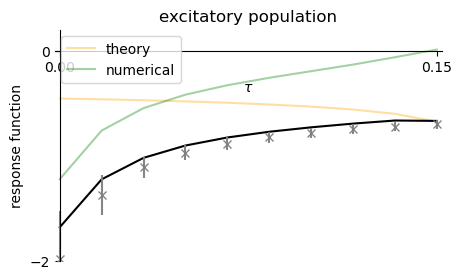

In [31]:
### compare response_func with response_func_num, average across the first dimension 
dtau = tau_series[1]-tau_series[0]
response_func_mean = np.nanmean(response_func[:,:,:],axis=0)
response_func_num_mean = np.nanmean(response_func_num[:,:,:],axis=0)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(tau_series,response_func_contribution[:,0,0],'orange',alpha=0.36)
ax.plot(tau_series,response_func_contribution[:,1,0],'green',alpha=0.36)

# ax.plot(tau_series,response_func_contribution[:,0,0]+response_func_contribution[:,1,0],'green',marker='o',alpha=0.36)
ax.plot(tau_series,response_func_mean[:,0],'k')
### numerical using filled_between 
# ax.fill_between(tau_series,response_func_num_mean[:,0]+np.nanstd(response_func_num[:,:,:],axis=0)[:,0],response_func_num_mean[:,0]-np.nanstd(response_func_num[:,:,:],axis=0)[:,0],color='k',alpha=0.3)
alphass = 0.95
ax.errorbar(tau_series[:],response_func_num_mean[:,0],yerr=np.nanstd(response_func_num[:,:,:],axis=0)[:,0],fmt='x',color='tab:gray',ecolor='tab:gray',alpha=alphass,ls='',elinewidth=1.5)
# ax.plot(tau_series,response_func_num_mean[:,1],'r',marker='o')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('response function')
ax.set_title('excitatory population')
ax.legend(['theory','numerical'])
### move x-axis at data 0, y-axis at 0 
ax.spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_position(('data',0))
### set yaxis, ylim not too large!
ax.set_ylim([-2,0.2])
ax.set_yticks([-2,0])
ax.set_xticks([0,tau_series[-1]])
ax.set_xlim([0-dtau/8,tau_series[-1]+dtau/8])

plt.show()

Fig 11(a) pointing from the yellow arrow to the purple arrow (horizontally)

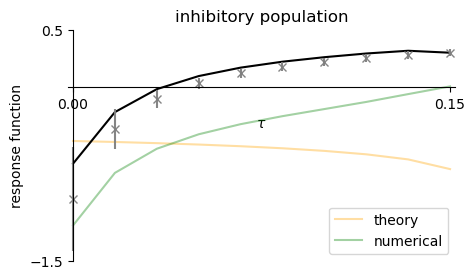

In [32]:
### compare response_func with response_func_num, average across the first dimension 
dtau = tau_series[1]-tau_series[0]
response_func_mean = np.nanmean(response_func[:,:,:],axis=0)
response_func_num_mean = np.nanmean(response_func_num[:,:,:],axis=0)
figinh, axinh = plt.subplots(figsize=(5,3))
axinh.plot(tau_series,response_func_contribution[:,0,1],'orange',alpha=0.36)
axinh.plot(tau_series,response_func_contribution[:,1,1],'green',alpha=0.36)
axinh.plot(tau_series,response_func_mean[:,1],'k')
alphass = 0.95
axinh.errorbar(tau_series[:],response_func_num_mean[:,1],yerr=np.nanstd(response_func_num[:,:,:],axis=0)[:,1],fmt='x',color='tab:gray',ecolor='tab:gray',alpha=alphass,ls='',elinewidth=1.5)

# ax.fill_between(tau_series,response_func_num_mean[:,1]+np.std(response_func_num[:,:,:],axis=0)[:,1],response_func_num_mean[:,1]-np.std(response_func_num[:,:,:],axis=0)[:,1],color='black',alpha=0.3)
# ax.plot(tau_series,response_func_num_mean[:,1],'r',marker='o')
axinh.set_xlabel(r'$\tau$')
axinh.set_ylabel('response function')
axinh.set_title('inhibitory population')
axinh.legend(['theory','numerical'])
### move x-axis at data 0, y-axis at 0 
axinh.spines['bottom'].set_position(('data',0))
### set other x-axis invisible
axinh.spines['top'].set_color('none')
axinh.spines['right'].set_color('none')
axinh.spines['left'].set_position(('data',0))
## set yaxis, ylim not too large!
# ax.set_ylim([-1,1])
# ax.set_ylim([-1,1.5])
axinh.set_ylim([-1.5,0.5])
axinh.set_xlim([0-dtau/8,tau_series[-1]+dtau/8])
axinh.set_xticks([0,tau_series[-1]])
axinh.set_yticks([-1.5,0.5])
plt.show()

#### Mode 2 Normal (Fig 11(a) purple arrow line)

$\tau_{EE}=\tau_{II}=-\tau_{EI}=-\tau_{IE}\in [0,0.15]$

In [35]:
### compute the theoretical outliers and the spectral radius
### recording
eigvchn_theo = np.zeros((ntau,2))
radius_theo_map = np.zeros(ntau)
### print variables and parameters of the adjacency matrix 
print('-------------------')
print('N:',N)
print('g:',g)
print('gamma:',gamma)
print('J:',J)
print('JE,JI:',JE,JI)
print('ge,gi:',ge,gi)
print('c:',c)
print('je,ji:',je,ji)
print('-------------------')
ce, ci = c,c
for it, tau in enumerate(tau_series):
    ### mean connectivity 
    je, ji = J, g*J
    hat_sigmae, hat_sigmai = np.sqrt(ce*(1-ce)),np.sqrt(ci*(1-ci))
    sigmae, sigmai = np.sqrt(je**2*ce*(1-ce)*N), np.sqrt(ji**2*ci*(1-ci)*N) 
    ### generate tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec
    tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec = np.zeros(2),np.zeros((2,2)),np.zeros((2,2)),np.zeros((2,2))
    ### YS: alltaus do not have E-I polarity
    tau_div_vec = np.array([tau,tau])
    tau_con_vec = np.array([[tau,tau],[tau,tau]])
    # tau_rec_vec = np.array([[0,0],[0,0]])
    tau_rec_vec = np.array([[2*tau,2*tau],[2*tau,2*tau]])
    tau_chn_vec = np.array([[tau,tau],[tau,tau]])
    # gamma = 1.0 ## NI/NE
    sigma = np.sqrt(sigmae**2/(1+gamma)+sigmai**2*gamma/(1+gamma))
    ### compute the radius 
    # compute a single number for multiple populations
    tau_div_num = hat_sigmae**2*tau_div_vec[0]+gamma*g**2*hat_sigmai**2*tau_div_vec[1]
    tau_div_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_div = tau_div_num/tau_div_den

    tau_con_num = hat_sigmae**2*tau_con_vec[0,0]+gamma*g**2*hat_sigmai**2*tau_con_vec[1,1]
    tau_con_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_con  = tau_con_num/tau_con_den

    tau_rec_num = hat_sigmae**2*tau_rec_vec[0,0] - (1+gamma)*g*hat_sigmae*hat_sigmai*tau_rec_vec[0,1]+gamma*g**2*hat_sigmai**2*tau_rec_vec[1,1]
    tau_rec_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_rec = tau_rec_num/tau_rec_den/2.0 

    tau_chn_num = hat_sigmae**2*tau_chn_vec[0,0] - 0.5*(1+gamma)*g*hat_sigmae*hat_sigmai*(tau_chn_vec[0,1]+tau_chn_vec[1,0])+gamma*g**2*hat_sigmai**2*tau_chn_vec[1,1]
    tau_chn_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_chn = tau_chn_num/tau_chn_den/2.0

    radius_theo = (1.0-tau_con-tau_div+tau_rec-2*tau_chn)/np.sqrt(1-tau_con-tau_div)*sigma
    
    radius_theo_map[it] = radius_theo
            
### theoretical prediction of the eigenvalues

org_k = J*N*(ALPHAE-g*ALPHAI)/2.0

eigvchn_theo[:,0] = org_k*(c+np.sqrt(c**2+4*c*(1-c)*tau_series))
eigvchn_theo[:,1] = org_k*(c-np.sqrt(c**2+4*c*(1-c)*tau_series))

-------------------
N: 1500
g: 6
gamma: 0.25
J: 0.00325
JE,JI: 0.7799999999999999 1.1700000000000002
ge,gi: 0.05034878350069642 0.3020927010041785
c: 0.2
je,ji: 0.00325 0.0195
-------------------


In [36]:
### sorting the 3 maximum eigvchn_series[:,-1,0].real and 3 minimum
eigvchn_real = eigvchn_series[:,-1,0].real.copy()
### sorting eigvchn_real 
idx = np.argsort(eigvchn_real)
idx_eff = idx[3:-3]#idx#
print('effective trials:',idx_eff,len(idx_eff))

effective trials: [12 23  5 10 11 18  1 35 14 24  0 26 28 16 27 19 30  2 29  8  4 21 20 13
 17 25  7 34 32 33] 30


In [37]:
### compute the numerical radius
radius_num_map = np.zeros((trials,ntau))
for ktrial in range(trials):
    for it in range(ntau): 
        eigvchn = eigvchn_series[ktrial,it,:].copy()

        eigvchn_real = np.real(eigvchn)
        eigvchn_real = np.sort(eigvchn_real)
        eigvchn_real = eigvchn_real[::-1]

        radius = (eigvchn_real[2])
        radius_num_map[ktrial,it] = radius


In [458]:
### plot the numerical and theoretical eigenvalues outliers
fig,ax = plt.subplots(figsize=(6,4))
### label is r_{bulk}^{num}
ax.plot(tau_series,radius_theo_map,'gray',linestyle='--',label=r'$r_{bulk}^{theo}$')
ax.plot(tau_series,-radius_theo_map,'gray',linestyle='--')
# ax.plot(tau_series,np.mean(radius_num_map,axis=0),'k',label=r'$r_{bulk}^{num}$')
ax.fill_between(tau_series,np.mean(radius_num_map,axis=0),-np.mean(radius_num_map,axis=0),color='gray',alpha=0.15,label=r'$r_{bulk}^{num}$')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Radius')
ax.legend()

ax.plot(tau_series,eigvchn_theo[:,0],'tab:red',label='theoretical')
ax.plot(tau_series,eigvchn_theo[:,1],'tab:green')

### plot error bar  
ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,0].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,0].real,axis=0),fmt='x',color='tab:red',ecolor='tab:red',alpha=1,ls='',elinewidth=1.5)

ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,1].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,1].real,axis=0),fmt='x',color='tab:green',ecolor='tab:green',alpha=1,ls='',elinewidth=1.5)
ax.plot((tau_series),(JE-JI)*np.ones_like(tau_series),c='gray')
    
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Outliers')
### set x and y lims as well as ticks
dtau = tau_series[1]-tau_series[0] 
ax.set_xlim([tau_series[0]-dtau/8,tau_series[-1]+dtau/8])
ax.set_xticks([tau_series[0],tau_series[-1]])
ax.set_ylim([-1.,0.5])
ax.set_yticks([-1,0,0.5])
ax.legend()
### move the x and y axis to the center
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',tau_series[0]))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.show()

In [38]:
# ### 
# trials = 36
# ntau = 10
# plt.close('all')
### compute the trial averaged mean 
mean_reigvec_series = np.zeros((trials,ntau,2,2)) ##rank, pop
mean_leigvec_series = np.zeros((trials,ntau,2,2)) ##rank, pop
mean_leig0vec_series = np.zeros((trials,ntau,2,2))
### numerical
mean_reigvec_num_series = np.zeros((trials,ntau,2,2))
mean_leigvec_num_series = np.zeros((trials,ntau,2,2))
mean_leig0vec_num_series = np.zeros((trials,ntau,2,2))
thl = 1.5
ths = 1.5
for ktrial in range(trials):
    for it in range(ntau):
        if it<2:
            threshold = ths
        else:
            threshold = thl
        for ir in range(2):
            mean_reigvec_series[ktrial,it,ir,0] = np.mean(intg_mean_series[ktrial,it,:NE,ir,1],axis=0)
            
            mean_reigvec_series[ktrial,it,ir,1] = np.mean(intg_mean_series[ktrial,it,NE:,ir,1],axis=0)
            
            mean_leigvec_series[ktrial,it,ir,0] = np.mean(intg_mean_series[ktrial,it,:NE,ir,0],axis=0)
            mean_leigvec_series[ktrial,it,ir,1] = np.mean(intg_mean_series[ktrial,it,NE:,ir,0],axis=0)
            # mean_leig0vec_series[ktrial,it,ir,0] = np.mean(leig0mean_series[ktrial,it,:NE,ir])
            # mean_leig0vec_series[ktrial,it,ir,1] = np.mean(leig0mean_series[ktrial,it,NE:,ir])
                
### for the numerical 
for ktrial in range(trials):
    for it in range(ntau):
        if it<2:
            threshold = ths
        else:
            threshold = thl
        for ir in range(2):
            mean_reigvec_num_series[ktrial,it,ir,0] = np.mean(eigrvec_series[ktrial,it,:NE,ir])
            mean_reigvec_num_series[ktrial,it,ir,1] = np.mean(eigrvec_series[ktrial,it,NE:,ir])
            mean_leigvec_num_series[ktrial,it,ir,0] = np.mean(eiglvec_series[ktrial,it,:NE,ir])
            mean_leigvec_num_series[ktrial,it,ir,1] = np.mean(eiglvec_series[ktrial,it,NE:,ir])
            mean_leig0vec_num_series[ktrial,it,ir,0] = np.mean(eiglvec0_series[ktrial,it,:NE,ir])
            mean_leig0vec_num_series[ktrial,it,ir,1] = np.mean(eiglvec0_series[ktrial,it,NE:,ir])
            
## select the middle 30 values 
kktrial = np.arange(trials)
cuts = 6
for it in range(ntau):
    for ir in range(2):
        ### only keep the middle 30 values of mean_reigvec_series[:,it,ir,0/1], osrt mean_reigvec_series[:,it,ir,0]
        idxsort = np.argsort(mean_reigvec_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:]) 
        mean_reigvec_series[idxnan,it,ir,0] = np.nan 
        idxnan = np.where(np.abs(mean_reigvec_series[:,it,ir,0].real)>threshold)[0]
        mean_reigvec_series[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_reigvec_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_reigvec_series[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_reigvec_series[:,it,ir,1].real)>threshold)[0]
        mean_reigvec_series[idxnan,it,ir,1] = np.nan
        
        
        idxsort = np.argsort(mean_leigvec_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_series[idxnan,it,ir,0] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_series[:,it,ir,0].real)>threshold)[0]
        mean_leigvec_series[idxnan,it,ir,0] = np.nan
    
            
        
        idxsort = np.argsort(mean_leigvec_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_series[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_series[:,it,ir,1].real)>threshold)[0]
        mean_leigvec_series[idxnan,it,ir,1] = np.nan
        
        idxsort = np.argsort(mean_reigvec_num_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:]) 
        mean_reigvec_num_series[idxnan,it,ir,0] = np.nan 
        idxnan = np.where(np.abs(mean_reigvec_num_series[:,it,ir,0].real)>threshold)[0]
        mean_reigvec_num_series[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_reigvec_num_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_reigvec_num_series[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_reigvec_num_series[:,it,ir,1].real)>threshold)[0]
        mean_reigvec_num_series[idxnan,it,ir,1] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series[idxnan,it,ir,0] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_num_series[:,it,ir,0].real)>threshold)[0]
        mean_leigvec_num_series[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_num_series[:,it,ir,1].real)>threshold)[0]
        mean_leigvec_num_series[idxnan,it,ir,1] = np.nan
        
        
        

In [39]:
mean_rvec = np.zeros((ntau,2,2))
mean_lvec = np.zeros((ntau,2,2))

for it in range(ntau):
    for ir in range(2):
        for ip in range(2):
            mean_rvec[it,ir,ip] = np.nanmean(mean_reigvec_num_series[:,it,ir,ip])
            mean_lvec[it,ir,ip] = np.nanmean(mean_leigvec_num_series[:,it,ir,ip])*eigvchn_theo[it,ir]
            
### compute the theoretical response function 
rank = 2
response_func_contribution = np.zeros((ntau,rank,2))
### compute the theoretical response function 
response_func = np.zeros((trials,ntau,2))
it = 0
response_func[:,it,1] = 1
for ir in range(1):
    response_func[:,it,0] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
    response_func[:,it,1] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
    
    response_func_contribution[it,ir,0] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
    response_func_contribution[it,ir,1] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)

    
for it in range(1,ntau):
    response_func[:,it,1] = 1
    if eigvchn_theo[it,1]<10:#radius_theo_map[it]:#eigvchn_theo[it-1,1]<radius_theo_map[it-1]:
        # response_func[:,it,:] = np.nan
        # response_func_contribution[it,:,:] = np.nan
        # continue  
        for ir in range(2):
            response_func[:,it,0] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func[:,it,1] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
            
            response_func_contribution[it,ir,0] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func_contribution[it,ir,1] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)


    
    else:
        for ir in range(2):
            response_func[:,it,0] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func[:,it,1] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
            
            response_func_contribution[it,ir,0] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func_contribution[it,ir,1] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)

        

In [45]:
### 
meanfr_eq = np.zeros((trials,ntau,2))
meanfr_pert = np.zeros((trials,ntau,2))
meanfr_eq[:,:,0] = np.mean(firing_rateeq[:,:,:NE],axis=2)
meanfr_eq[:,:,1] = np.mean(firing_rateeq[:,:,NE:],axis=2)
### same for pydll Creates ()
meanfr_pert[:,:,0] = np.mean(firing_ratepert[:,:,:NE],axis=2)
meanfr_pert[:,:,1] = np.mean(firing_ratepert[:,:,NE:],axis=2)
### numerical response function 
response_func_num = np.zeros((trials,ntau,2))
for ktrial in range(trials):
    for it in range(ntau):
        response_func_num[ktrial,it,0]=(meanfr_pert[ktrial,it,0]-meanfr_eq[ktrial,it,0])/Ipert[-1]
        response_func_num[ktrial,it,1]=(meanfr_pert[ktrial,it,1]-meanfr_eq[ktrial,it,1])/Ipert[-1]
        
#### delete the largest 3 and the smallest 3 from response_func_num
for it in range(ntau):
    idxsort = np.where(np.abs(response_func_num[:,it,0].copy())>10)
    idxnan = (idxsort) 
    response_func_num[idxnan,it,0] = np.nan 
    
    
    idxsort = np.where(np.abs(response_func_num[:,it,1].copy())>10)
    idxnan = (idxsort) 
    response_func_num[idxnan,it,1] = np.nan 

In [46]:

### compare response_func with response_func_num, average across the first dimension 
dtau = tau_series[1]-tau_series[0]
response_func_mean = np.nanmean(response_func[:,:,:],axis=0)
response_func_num_mean = np.nanmean(response_func_num[:,:,:],axis=0)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(tau_series,response_func_contribution[:,0,0],'orange',marker='o',alpha=0.36)
ax.plot(tau_series,response_func_contribution[:,1,0],'green',marker='o',alpha=0.36)
ax.plot(tau_series,response_func_mean[:,0],'k',marker='o')
# ### numerical using filled_between 
# ax.fill_between(tau_series,response_func_num_mean[:,0]+np.nanstd(response_func_num[:,:,:],axis=0)[:,0],response_func_num_mean[:,0]-np.nanstd(response_func_num[:,:,:],axis=0)[:,0],color='k',alpha=0.3)
alphass = 0.95
ax.errorbar(tau_series[:],response_func_num_mean[:,0],yerr=np.nanstd(response_func_num[:,:,:],axis=0)[:,0],fmt='x',color='tab:gray',ecolor='tab:gray',alpha=alphass,ls='',elinewidth=1.5)
# ax.plot(tau_series,response_func_num_mean[:,1],'r',marker='o')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('response function')
ax.set_title('excitatory population')
ax.legend(['theory','numerical'])
### move x-axis at data 0, y-axis at 0 
ax.spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_position(('data',tau_series[0]))
### set yaxis, ylim not too large!
ax.set_ylim([-2,2])
ax.set_yticks([-2,2])
ax.set_ylim([-1.5,0.5])
ax.set_yticks([-1.5,0.5])
ax.set_xlim([tau_series[0]-dtau/8,tau_series[-1]+dtau/8])
ax.set_xticks([tau_series[0],0.15,tau_series[-1]])
plt.show()

In [47]:
### compare response_func with response_func_num, average across the first dimension 
dtau = tau_series[1]-tau_series[0]
response_func_mean = np.nanmean(response_func[:,:,:],axis=0)
response_func_num_mean = np.nanmean(response_func_num[:,:,:],axis=0)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(tau_series,response_func_contribution[:,0,1],'orange',marker='o',alpha=0.36)
ax.plot(tau_series,response_func_contribution[:,1,1],'green',marker='o',alpha=0.36)
ax.plot(tau_series,response_func_mean[:,1],'k',marker='o')
alphass = 0.95
ax.errorbar(tau_series[:],response_func_num_mean[:,1],yerr=np.nanstd(response_func_num[:,:,:],axis=0)[:,1],fmt='x',color='tab:gray',ecolor='tab:gray',alpha=alphass,ls='',elinewidth=1.5)

# ax.fill_between(tau_series,response_func_num_mean[:,1]+np.std(response_func_num[:,:,:],axis=0)[:,1],response_func_num_mean[:,1]-np.std(response_func_num[:,:,:],axis=0)[:,1],color='black',alpha=0.3)
# ax.plot(tau_series,response_func_num_mean[:,1],'r',marker='o')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('response function')
ax.set_title('inhibitory population')
ax.legend(['theory','numerical'])
### move x-axis at data 0, y-axis at 0 
ax.spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_position(('data',tau_series[0]))
## set yaxis, ylim not too large!
ax.set_ylim([-1,1])
ax.set_ylim([-1,1.5])
ax.set_ylim([-1,0.5])
ax.set_ylim([-1.5,0.5])
ax.set_xlim([tau_series[0]-dtau/8,tau_series[-1]+dtau/8])
ax.set_xticks([tau_series[0],0.15,tau_series[-1]])
ax.set_yticks([-1.5,0.5])
plt.show()

#### Mode#3 nonnegative(transition) Fig 11(b,c) Gaussian Approximation

$\tau_{EE}=\tau_{II}\in[0,0.15],\,\,\,\,\tau_{EI}=\tau_{IE}==0$

In [34]:
data_name = "E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/equivalentGaussian/ConnStats_WD_AdjGau_22May_t200ms_PRX_N1500_nonneg_nonparadoxical_INHparadoxical.npz"#ConnStats_WD_AdjGau_22May_t200ms_PRX_N1500_nonneg_nonparadoxical_INHparadoxical.npz"
# data_name = "/Users/shaoyuxiu/Library/CloudStorage/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/equivalentGaussian/ConnStats_WD_AdjGau_22May_t200ms_PRX_N1500_nonneg_nonparadoxical_INHparadoxical.npz"#

# np.savez(data_name, **data)
### load data  
data = np.load(data_name,allow_pickle=True)
eigvchn_series = data['eigvchn_series']
eigrvec_series = data['eigrvec_series']
eiglvec_series = data['eiglvec_series']
eiglvec0_series = data['eiglvec0_series']
params = data['params']


firing_rateeq = data['firing_rateeq']
firing_ratepert = data['firing_ratepert']

g = params[()]['g']
gamma = params[()]['gamma']
NE = params[()]['NE']
NI = params[()]['NI']
J = params[()]['J']
ce = params[()]['ce']
ci = params[()]['ci']
tau_series = params[()]['tau_series']

In [ ]:
'''Mode 3 nonnegative'''
nvec, mvec = np.zeros((N,1)), np.ones((N,1))
nvec[:NE,0], nvec[NE:,0] = JE/NE, -JI/NI
def case1eigv(x,J,g,NE,NI,c,tau):
    tauc = np.abs(tau)
    zee = J**2*c*(1-c)*NE*tauc-g*J**2*c*(1-c)*NI*0
    zii = -g*J**2*c*(1-c)*NE*0+g**2*J**2*c*(1-c)*NI*tauc 
    # print((NE*zee+NI*zii)*4+(JE-JI)**2)
    z2lambda = np.zeros((N,N))
    z2lambda[:,:NE], z2lambda[:,NE:] = zee/x**2,zii/x**2 
    z2lambda = np.eye(N)-z2lambda 
    final = nvec.T@la.inv(z2lambda)@mvec 
    final = np.squeeze(final)
    return final-x

### solve x 
eigvchn_theo = np.zeros((ntau,2))
for it, tau in enumerate(tau_series):
    if it<=-1:
        continue
    x = fsolve(case1eigv,np.mean(eigvchn_series[:,it,1].real),args=(J,g,NE,NI,c,tau))
    eigvchn_theo[it,1] = x 
    print('tau:',tau,'eigv:',x)
    x = fsolve(case1eigv,np.mean((eigvchn_series[:,it,0]).real),args=(J,g,NE,NI,c,tau))
    eigvchn_theo[it,0] = x 
    
    print('tau:',tau,'eigv:',x)
    print('numerical:',np.mean(eigvchn_series[:,it,:2],axis=0))


In [36]:
### sorting the 3 maximum eigvchn_series[:,-1,0].real and 3 minimum
eigvchn_real = eigvchn_series[:,-1,0].real.copy()
### sorting eigvchn_real 
idx = np.argsort(eigvchn_real)
idx_eff = idx[3:-3]#idx#
print('effective trials:',idx_eff,len(idx_eff))

### compute the numerical radius
radius_num_map = np.zeros((trials,ntau))
for ktrial in range(trials):
    for it in range(ntau): 
        eigvchn = eigvchn_series[ktrial,it,:].copy()

        eigvchn_real = np.real(eigvchn)
        eigvchn_real = np.sort(eigvchn_real)
        eigvchn_real = eigvchn_real[::-1]

        radius = (eigvchn_real[2])
        radius_num_map[ktrial,it] = radius


effective trials: [11 33  7 24 10 21 28 35  8  9 23 34 18  4 14 15  3 13 31 20 25  2 12 30
 27 16 32  1 19  0] 30


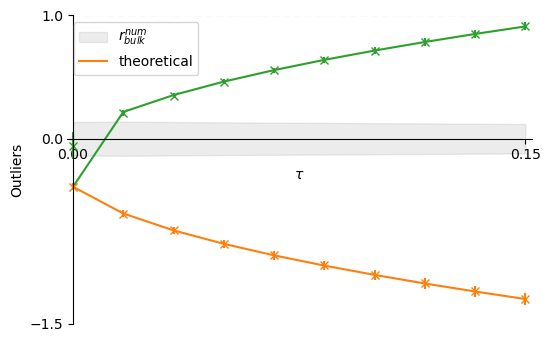

In [37]:
### plot the numerical and theoretical eigenvalues outliers
fig,ax = plt.subplots(figsize=(6,4))
### label is r_{bulk}^{num}
# ax.plot(tau_series,np.mean(radius_num_map,axis=0),'k',label=r'$r_{bulk}^{num}$')
ax.fill_between(tau_series,np.mean(radius_num_map,axis=0),-np.mean(radius_num_map,axis=0),color='gray',alpha=0.15,label=r'$r_{bulk}^{num}$')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Radius')
ax.legend()

ax.plot(tau_series,eigvchn_theo[:,0],'tab:orange',label='theoretical')
ax.plot(tau_series,eigvchn_theo[:,1],'tab:green')

### plot error bar  
ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,0].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,0].real,axis=0),fmt='x',color='tab:orange',ecolor='tab:orange',alpha=1,ls='',elinewidth=1.5)

ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,1].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,1].real,axis=0),fmt='x',color='tab:green',ecolor='tab:green',alpha=1,ls='',elinewidth=1.5)
# ax.plot((tau_series),(JE-JI)*np.ones_like(tau_series),c='gray')
ax.plot((tau_series),1*np.ones_like(tau_series),c='gray',ls='--')
    
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Outliers')
### set x and y lims as well as ticks
dtau = tau_series[1]-tau_series[0] 
ax.set_xlim([tau_series[0]-dtau/8,tau_series[-1]+dtau/8])
ax.set_xticks([tau_series[0],tau_series[-1]])
ax.set_ylim([-1.5,1.])
ax.set_yticks([-1.5,0,1.])
ax.legend()
### move the x and y axis to the center
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',tau_series[0]))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.show()

In [38]:
# ### 
# trials = 36
# ntau = 10
# plt.close('all')
### compute the trial averaged mean 
### numerical
mean_reigvec_num_series = np.zeros((trials,ntau,2,2))
mean_leigvec_num_series = np.zeros((trials,ntau,2,2))
mean_leig0vec_num_series = np.zeros((trials,ntau,2,2))
thl = 1.5
ths = 1.5
                
### for the numerical 
for ktrial in range(trials):
    for it in range(ntau):
        if it<2:
            threshold = ths
        else:
            threshold = thl
        for ir in range(2):
            mean_reigvec_num_series[ktrial,it,ir,0] = np.mean(eigrvec_series[ktrial,it,:NE,ir])
            mean_reigvec_num_series[ktrial,it,ir,1] = np.mean(eigrvec_series[ktrial,it,NE:,ir])
            mean_leigvec_num_series[ktrial,it,ir,0] = np.mean(eiglvec_series[ktrial,it,:NE,ir])
            mean_leigvec_num_series[ktrial,it,ir,1] = np.mean(eiglvec_series[ktrial,it,NE:,ir])
            mean_leig0vec_num_series[ktrial,it,ir,0] = np.mean(eiglvec0_series[ktrial,it,:NE,ir])
            mean_leig0vec_num_series[ktrial,it,ir,1] = np.mean(eiglvec0_series[ktrial,it,NE:,ir])
            
## select the middle 30 values 
kktrial = np.arange(trials)
cuts = 6
for it in range(ntau):
    for ir in range(2):
        
        idxsort = np.argsort(mean_reigvec_num_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:]) 
        mean_reigvec_num_series[idxnan,it,ir,0] = np.nan 
        idxnan = np.where(np.abs(mean_reigvec_num_series[:,it,ir,0].real)>threshold)[0]
        mean_reigvec_num_series[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_reigvec_num_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_reigvec_num_series[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_reigvec_num_series[:,it,ir,1].real)>threshold)[0]
        mean_reigvec_num_series[idxnan,it,ir,1] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series[idxnan,it,ir,0] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_num_series[:,it,ir,0].real)>threshold)[0]
        mean_leigvec_num_series[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_num_series[:,it,ir,1].real)>threshold)[0]
        mean_leigvec_num_series[idxnan,it,ir,1] = np.nan
        
        
        

In [44]:
mean_rvec = np.zeros((ntau,2,2))
mean_lvec = np.zeros((ntau,2,2))

for it in range(ntau):
    for ir in range(2):
        for ip in range(2):
            mean_rvec[it,ir,ip] = np.nanmean(mean_reigvec_num_series[:,it,ir,ip])
            mean_lvec[it,ir,ip] = np.nanmean(mean_leigvec_num_series[:,it,ir,ip])*eigvchn_theo[it,ir]
            
### compute the theoretical response function 
rank = 2
response_func_contribution = np.zeros((ntau,rank,2))
### compute the theoretical response function 
response_func = np.zeros((trials,ntau,2))
it = 0
response_func[:,it,1] = 1
for ir in range(1):
    response_func[:,it,0] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
    response_func[:,it,1] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
    
    response_func_contribution[it,ir,0] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
    response_func_contribution[it,ir,1] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)

    
for it in range(1,ntau):
    response_func[:,it,1] = 1
    if eigvchn_theo[it,1]<10:#np.mean(radius_num_map[:,it]):
        # response_func[:,it,:] = np.nan
        # response_func_contribution[it,:,:] = np.nan
        # continue  
        for ir in range(2):
            response_func[:,it,0] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func[:,it,1] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
            
            response_func_contribution[it,ir,0] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func_contribution[it,ir,1] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)


    
    else:
        for ir in range(2):
            response_func[:,it,0] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func[:,it,1] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
            
            response_func_contribution[it,ir,0] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func_contribution[it,ir,1] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
        

In [45]:
### 
meanfr_eq = np.zeros((trials,ntau,2))
meanfr_pert = np.zeros((trials,ntau,2))
meanfr_eq[:,:,0] = np.mean(firing_rateeq[:,:,:NE],axis=2)
meanfr_eq[:,:,1] = np.mean(firing_rateeq[:,:,NE:],axis=2)
### same for pydll Creates ()
meanfr_pert[:,:,0] = np.mean(firing_ratepert[:,:,:NE],axis=2)
meanfr_pert[:,:,1] = np.mean(firing_ratepert[:,:,NE:],axis=2)
### numerical response function 
response_func_num = np.zeros((trials,ntau,2))
for ktrial in range(trials):
    for it in range(ntau):
        response_func_num[ktrial,it,0]=(meanfr_pert[ktrial,it,0]-meanfr_eq[ktrial,it,0])/Ipert[-1]
        response_func_num[ktrial,it,1]=(meanfr_pert[ktrial,it,1]-meanfr_eq[ktrial,it,1])/Ipert[-1]
        
#### delete the largest 3 and the smallest 3 from response_func_num
for it in range(ntau):
    idxsort = np.where(np.abs(response_func_num[:,it,0].copy())>10)
    idxnan = (idxsort) 
    response_func_num[idxnan,it,0] = np.nan 
    
    
    idxsort = np.where(np.abs(response_func_num[:,it,1].copy())>10)
    idxnan = (idxsort) 
    response_func_num[idxnan,it,1] = np.nan 

Fig 11(b) Gaussian Approximation

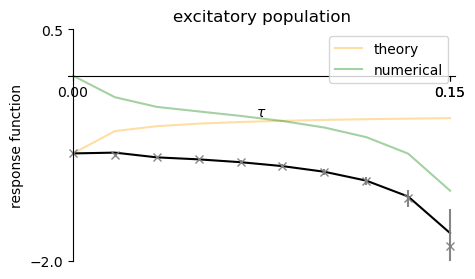

In [47]:

### compare response_func with response_func_num, average across the first dimension 
dtau = tau_series[1]-tau_series[0]
response_func_mean = np.nanmean(response_func[:,:,:],axis=0)
response_func_num_mean = np.nanmean(response_func_num[:,:,:],axis=0)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(tau_series,response_func_contribution[:,0,0],'orange',alpha=0.36)
ax.plot(tau_series,response_func_contribution[:,1,0],'green',alpha=0.36)
ax.plot(tau_series,response_func_mean[:,0],'k')
# ### numerical using filled_between 
# ax.fill_between(tau_series,response_func_num_mean[:,0]+np.nanstd(response_func_num[:,:,:],axis=0)[:,0],response_func_num_mean[:,0]-np.nanstd(response_func_num[:,:,:],axis=0)[:,0],color='k',alpha=0.3)
alphass = 0.95
ax.errorbar(tau_series[:],response_func_num_mean[:,0],yerr=np.nanstd(response_func_num[:,:,:],axis=0)[:,0],fmt='x',color='tab:gray',ecolor='tab:gray',alpha=alphass,ls='',elinewidth=1.5)
# ax.plot(tau_series,response_func_num_mean[:,1],'r',marker='o')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('response function')
ax.set_title('excitatory population')
ax.legend(['theory','numerical'])
### move x-axis at data 0, y-axis at 0 
ax.spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_position(('data',tau_series[0]))
### set yaxis, ylim not too large!
ax.set_ylim([-2,2])
ax.set_yticks([-2,2])
ax.set_ylim([-2,0.5])
ax.set_yticks([-2,0.5])
ax.set_xlim([tau_series[0]-dtau/8,tau_series[-1]+dtau/8])
ax.set_xticks([tau_series[0],0.15,tau_series[-1]])
plt.show()

Fig 11(c) Gaussian Approximation

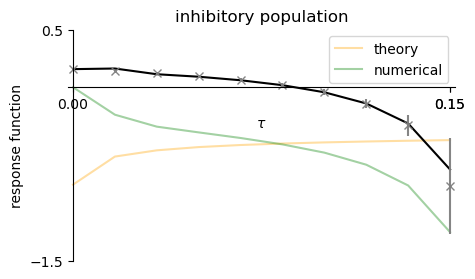

In [48]:
### compare response_func with response_func_num, average across the first dimension 
dtau = tau_series[1]-tau_series[0]
response_func_mean = np.nanmean(response_func[:,:,:],axis=0)
response_func_num_mean = np.nanmean(response_func_num[:,:,:],axis=0)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(tau_series,response_func_contribution[:,0,1],'orange',alpha=0.36)
ax.plot(tau_series,response_func_contribution[:,1,1],'green',alpha=0.36)
ax.plot(tau_series,response_func_mean[:,1],'k')
alphass = 0.95
ax.errorbar(tau_series[:],response_func_num_mean[:,1],yerr=np.nanstd(response_func_num[:,:,:],axis=0)[:,1],fmt='x',color='tab:gray',ecolor='tab:gray',alpha=alphass,ls='',elinewidth=1.5)

# ax.fill_between(tau_series,response_func_num_mean[:,1]+np.std(response_func_num[:,:,:],axis=0)[:,1],response_func_num_mean[:,1]-np.std(response_func_num[:,:,:],axis=0)[:,1],color='black',alpha=0.3)
# ax.plot(tau_series,response_func_num_mean[:,1],'r',marker='o')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('response function')
ax.set_title('inhibitory population')
ax.legend(['theory','numerical'])
### move x-axis at data 0, y-axis at 0 
ax.spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_position(('data',tau_series[0]))
## set yaxis, ylim not too large!
ax.set_ylim([-1,1])
ax.set_ylim([-1,1.5])
ax.set_ylim([-1,0.5])
ax.set_ylim([-1.5,0.5])
ax.set_xlim([tau_series[0]-dtau/8,tau_series[-1]+dtau/8])
ax.set_xticks([tau_series[0],0.15,tau_series[-1]])
ax.set_yticks([-1.5,0.5])
plt.show()

#### save data

In [432]:
def list_to_dict(lst, string):
    """
    Transform a list of variables into a dictionary.
    Parameters
    ----------
    lst : list
        list with all variables.
    string : str
        string containing the names, separated by commas.
    Returns
    -------
    d : dict
        dictionary with items in which the keys and the values are specified
        in string and lst values respectively.
    """
    string = string[0]
    string = string.replace(']', '')
    string = string.replace('[', '')
    string = string.replace('\\', '')
    string = string.replace(' ', '')
    string = string.replace('\t', '')
    string = string.replace('\n', '')
    string = string.split(',')
    d = {s: v for s, v in zip(string, lst)}
    return d

In [34]:
# data_name = "E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/equivalentGaussian/ConnStats_WD_AdjGau_22May_t200ms_PRX_N1500_homo_nonparadoxical_INHparadoxical.npz"#ConnStats_WD_AdjGau_22May_t200ms_PRX_N1500_nonneg_nonparadoxical_INHparadoxical.npz"
data_name = "/Users/shaoyuxiu/Library/CloudStorage/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/equivalentGaussian/ConnStats_WD_AdjGau_22May_t200ms_PRX_N1500_homo_nonparadoxical_INHparadoxical.npz"#

### load data  
data = np.load(data_name,allow_pickle=True)
eigvchn_series = data['eigvchn_series']
eigrvec_series = data['eigrvec_series']
eiglvec_series = data['eiglvec_series']
eiglvec0_series = data['eiglvec0_series']
params = data['params']

firing_rateeq = data['firing_rateeq']
firing_ratepert = data['firing_ratepert']

g = params[()]['g']
gamma = params[()]['gamma']
NE = params[()]['NE']
NI = params[()]['NI']
J = params[()]['J']
ce = params[()]['ce']
ci = params[()]['ci']
tau_series = params[()]['tau_series']

In [436]:
g,J

(6, 0.00325)